In [10]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/0/
  inflating: dataset/0/0 (0).jpg     
  inflating: dataset/0/0 (1).jpg     
  inflating: dataset/0/0 (2).jpg     
  inflating: dataset/0/0 (3).jpg     
  inflating: dataset/0/0 (4).jpg     
  inflating: dataset/0/0 (5).jpg     
  inflating: dataset/0/0 (6).jpg     
  inflating: dataset/0/0 (7).jpg     
  inflating: dataset/0/0 (8).jpg     
  inflating: dataset/0/0 (9).jpg     
   creating: dataset/1/
  inflating: dataset/1/1 (0).jpg     
  inflating: dataset/1/1 (1).jpg     
  inflating: dataset/1/1 (2).jpg     
  inflating: dataset/1/1 (3).jpg     
  inflating: dataset/1/1 (4).jpg     
  inflating: dataset/1/1 (5).jpg     
  inflating: dataset/1/1 (6).jpg     
  inflating: dataset/1/1 (7).jpg     
  inflating: dataset/1/1 (8).jpg     
  inflating: dataset/1/1 (9).jpg     
   creating: dataset/2/
  inflating: dataset/2/2 (0).jpg     
  inflating: dataset/2/2 (1).jpg     
  inflating: dataset/2/2 (2).jpg     
  inflatin

In [13]:
import os
import random
import string
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import shutil
# Define the size of the image
IMAGE_WIDTH = 72
IMAGE_HEIGHT = 72

# Define the path to the Thai font file
THAI_FONT_FILE = "Sarun's_ThangLuang.ttf"
# Define the characters to be included in the dataset
CHARACTERS = ''.join([
    '0123456789',  # Numbers
    'กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮ'  # Thai characters
])

# Define the number of images to be generated for each character
NUM_IMAGES_PER_CHARACTER = 10

# Define the output directory for the dataset
OUTPUT_DIR = 'dataset/'


# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Load the Thai font
font = ImageFont.truetype(THAI_FONT_FILE, IMAGE_WIDTH)

# Generate the images
for char in CHARACTERS:
    if not os.path.exists(OUTPUT_DIR+char):
        os.makedirs(OUTPUT_DIR+char)
    for i in range(NUM_IMAGES_PER_CHARACTER):
        # Create a new image
        image = Image.new('L', (IMAGE_WIDTH, IMAGE_HEIGHT), color=255)
        
        # Draw the character on the image
        draw = ImageDraw.Draw(image)
        draw.text((20, -50), char, fill=0, font=font)
        
        # Add noise to the image
        image_array = np.array(image)
        noise = np.random.normal(0, 10, size=(IMAGE_HEIGHT, IMAGE_WIDTH))
        image_array = np.clip(image_array + noise, 0, 255).astype(np.uint8)
        image = Image.fromarray(image_array)
        
        # Save the image
        filename = f'{char} ({i}).jpg'
        filepath = os.path.join(OUTPUT_DIR+char, filename)
        image.save(filepath)


In [23]:
import keras
from keras.datasets import cifar10
from keras.utils import image_dataset_from_directory, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import numpy as np
import os, random, tensorflow as tf

def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed(1234)

datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.2,0.8),
    shear_range=0.2,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=True,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train = datagen.flow_from_directory('dataset', subset="training", color_mode = 'grayscale',batch_size=20, seed=1234,target_size=(72, 72),shuffle=True,seed=1234)
val = test_datagen.flow_from_directory('dataset',subset="validation", color_mode = 'grayscale',batch_size=20, seed=1234,target_size=(72, 72),shuffle=True,seed=1234)





num_classes = len(train.class_indices)

labels = dict((v,k) for k,v in train.class_indices.items())


Found 1262 images belonging to 54 classes.
Found 302 images belonging to 54 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [22]:



model_1 = Sequential()


model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=(72,72,1)))
model_1.add(Activation('relu'))
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

batch_size = 64

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(train)
STEP_SIZE_TRAIN=train.n//train.batch_size
STEP_SIZE_VALID=val.n//val.batch_size
model_1.fit_generator(generator=train,
            steps_per_epoch=STEP_SIZE_TRAIN,
            epochs=150,
            validation_steps=STEP_SIZE_VALID,
            validation_data=val)

model_1.save('OCR.h5')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 36, 36, 32)        832       
                                                                 
 activation_8 (Activation)   (None, 36, 36, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        25632     
                                                                 
 activation_9 (Activation)   (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 32)          0         
                                                      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-22-eb630bf670fe>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_1.fit_generator(generator=train,
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


63/63 [==============================] - 7s 100ms/step - loss: 3.9779 - accuracy: 0.0242 - val_loss: 3.9301 - val_accuracy: 0.0233
Epoch 2/150
63/63 [==============================] - 6s 92ms/step - loss: 3.9553 - accuracy: 0.0225 - val_loss: 3.8974 - val_accuracy: 0.0233
Epoch 3/150
63/63 [==============================] - 7s 115ms/step - loss: 3.9186 - accuracy: 0.0193 - val_loss: 3.8855 - val_accuracy: 0.0333
Epoch 4/150
63/63 [==============================] - 6s 95ms/step - loss: 3.8765 - accuracy: 0.0306 - val_loss: 3.7835 - val_accuracy: 0.0567
Epoch 5/150
63/63 [==============================] - 6s 100ms/step - loss: 3.7990 - accuracy: 0.0451 - val_loss: 3.7236 - val_accuracy: 0.0467
Epoch 6/150
63/63 [==============================] - 7s 115ms/step - loss: 3.7279 - accuracy: 0.0636 - val_loss: 3.6202 - val_accuracy: 0.0767
Epoch 7/150
63/63 [==============================] - 7s 107ms/step - loss: 3.6232 - accuracy: 0.0730 - val_loss: 3.5566 - val_accuracy: 0.0600
Epoch 8/150
6

142


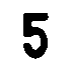

1/1 [==============================] - 0s 114ms/step


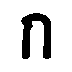

1/1 [==============================] - 0s 36ms/step


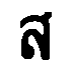

1/1 [==============================] - 0s 56ms/step


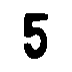

1/1 [==============================] - 0s 32ms/step


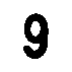

1/1 [==============================] - 0s 30ms/step


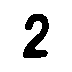

1/1 [==============================] - 0s 36ms/step


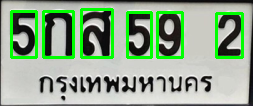

Vehicle plate: 5ภส592


In [32]:
import cv2
import imutils
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
import functools
import numpy as np
from google.colab.patches import cv2_imshow

original_image = cv2.imread('image9.jpg')
#cv2.imshow('image',original_image)

original_image = imutils.resize(original_image, width=500 )
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY) 
gray_image = cv2.bilateralFilter(gray_image, 11, 17, 17)

#cv2.imshow('image',original_image)
#cv2.imshow('image',gray_image)

edged_image = cv2.Canny(gray_image, 10, 200)
#cv2.imshow('image',edged_image)


contours, new = cv2.findContours(edged_image.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
img1 = original_image.copy()
cv2.drawContours(img1, contours, -1, (0, 0,255), 3)
#cv2.imshow('image',img1)
print(len(contours))


contours = sorted(contours, key = cv2.contourArea, reverse = True)[:100]
screenCnt = None
img2 = original_image.copy()

cv2.drawContours(img2, contours, -1, (0, 0,255), 3)
#cv2_imshow(img2)

count = 0
idx = 7

for c in contours :
    contour_perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * contour_perimeter, True)

    if len(approx) == 4:
        screenCnt = approx
        x, y, w, h = cv2.boundingRect(c)
        new_img = original_image [ y: y + h, x: x + w]
        cv2.imwrite('cropped.png',new_img)
        idx += 1
        break
        
cv2.drawContours(original_image , [screenCnt], -1, (0, 0,255), 3)
#cv2.imshow('image',original_image )


cropped_License_Plate = 'cropped.png' 




image = cv2.imread(cropped_License_Plate)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)


_, labels = cv2.connectedComponents(thresh)
mask = np.zeros(thresh.shape, dtype="uint8")


total_pixels = image.shape[0] * image.shape[1]
lower = total_pixels // 70 
upper = total_pixels // 20 


for (i, label) in enumerate(np.unique(labels)):

    if label == 0:
        continue
 

    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
 

    if numPixels > lower and numPixels < upper:
        mask = cv2.add(mask, labelMask)
        

cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in cnts]


def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 10:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]
boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare) )


TARGET_WIDTH = 72
TARGET_HEIGHT = 72
chars = ''.join([
    '0123456789',
    'กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮ' 
])
model = load_model('OCR.h5')

vehicle_plate = ""

for rect in boundingBoxes:

    x,y,w,h = rect

    crop = mask[y:y+h, x:x+w]
    crop = cv2.bitwise_not(crop)

    rows = crop.shape[0]
    columns = crop.shape[1]

    if rows > TARGET_HEIGHT or columns > TARGET_WIDTH:
      continue
    paddingY = (TARGET_HEIGHT - rows) // 2 if rows < TARGET_HEIGHT else int(0.17 * rows)
    paddingX = (TARGET_WIDTH - columns) // 2 if columns < TARGET_WIDTH else int(0.45 * columns)
    

    crop = cv2.copyMakeBorder(crop, paddingY, paddingY, paddingX, paddingX, cv2.BORDER_CONSTANT, None, 255)

    crop = cv2.resize(crop, (TARGET_WIDTH, TARGET_HEIGHT))
    cv2_imshow(crop)

    crop = crop.astype("float") / 255.0
    crop = img_to_array(crop)
    crop = np.expand_dims(crop, axis=0)

    prob = model.predict(crop)[0]
    idx = np.argsort(prob)[-1]
    vehicle_plate += chars[idx]

    cv2.rectangle(image, (x,y), (x+w,y+h), (0, 255, 0), 2)
    
# Show final image
cv2_imshow(image)
print("Vehicle plate: " + vehicle_plate)
